## Classification with a Multi-layer Perceptron (MLP)

Author: V. Ashley Villar

In this problem set, we will *not* be implementing neural networks from scratch. Yesterday, you built a *perceptron* in Python. Multi-layer perceptrons (MLPs) are, as discussed in the lecture, several layers of these perceptrons stacked. Here, we will learn how to use one of the most common modules for building neural networks: Pytorch

In [ ]:
!pip install astronn
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

     |████████████████████████████████| 9.3 MB 27.0 MB/s 
     |████████████████████████████████| 4.5 MB 12.8 MB/s 
     |████████████████████████████████| 832 kB 21.2 MB/s 
     |████████████████████████████████| 54 kB 1.1 MB/s 
     |████████████████████████████████| 3.6 MB 40.2 MB/s 
  Created wheel for astronn: filename=astroNN-1.0.1-py3-none-any.whl size=9284595 sha256=92508bd0a3064823737aee5f2f16bc4c45d2855fe32ba54ecc19b413c43cbbb7
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astronn


# Problem 1: Understanding the Data

For this problem set, we will use the Galaxy10 dataset made available via the astroNN module. This dataset is made up of 17736 images of galaxies which have been labelled by hand. See this [link](https://astronn.readthedocs.io/en/latest/galaxy10.html) for more information. 

First we will visualize our data.

**Problem 1a** Show one example of each class as an image.



WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


Galaxy10.h5:  99%|█████████▉| 208M/210M [00:21<00:00, 14.2MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:22, 9.41MB/s]                           


21785
0 3461


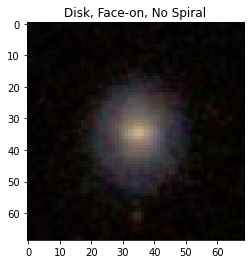

1 6997


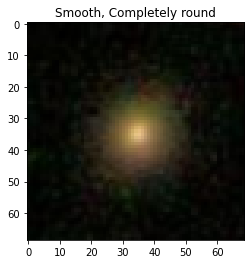

2 6292


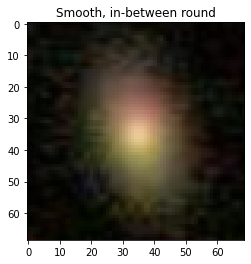

3 349


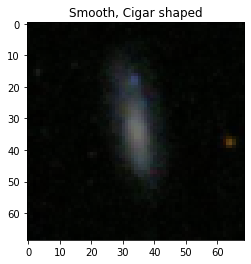

4 1534


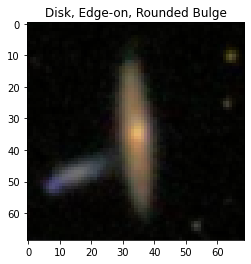

5 17


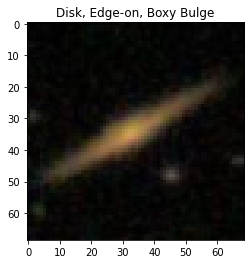

6 589


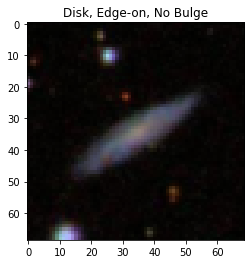

7 1121


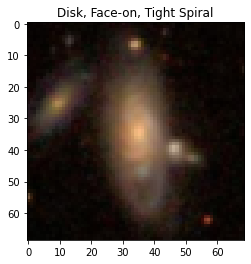

8 906


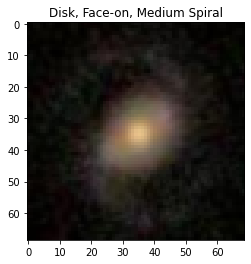

9 519


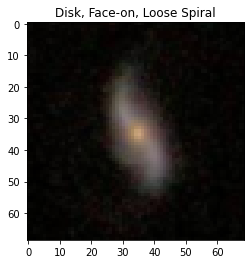

In [ ]:
from astroNN.datasets import load_galaxy10
images, labels_original = load_galaxy10()
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
%matplotlib inline

# Plot an example image from each class

# First, find an example of each class
uclasses, counts = np.unique(labels_original,return_counts=True)
print(len(labels_original))
for i, uclass in enumerate(uclasses):
  print(uclass,counts[i])
  first_example = np.where(labels_original==uclass)[0][0]
  plt.imshow(images[first_example])
  plt.title(galaxy10cls_lookup(uclass))
  plt.show()

**Problem 2b** Make a histogram showing the fraction of each class

Keep only the top two classes (i.e., the classes with the most galaxies)

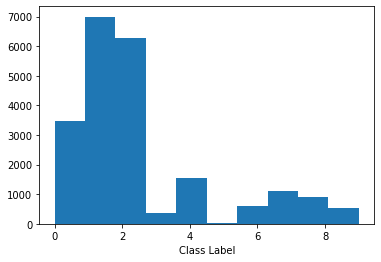

In [ ]:
plt.hist(labels_original)
plt.xlabel('Class Label')
plt.show()


#Only work with 1 and 2
gind = np.where((labels_original==1) | (labels_original==2))
images_top_two = images[gind]
labels_top_two = labels_original[gind]

This next block of code converts the data to a format which is more compatible with our neural network.

In [ ]:
import torch.nn.functional as F
torch.set_default_dtype(torch.float)
labels_top_two_one_hot = F.one_hot(torch.tensor(labels_top_two - np.min(labels_top_two)).long(), num_classes=2)
images_top_two = torch.tensor(images_top_two).float()
labels_top_two_one_hot = labels_top_two_one_hot.float()
# we're going to flatten the images for our MLP
images_top_two_flat = images_top_two.reshape(len(images_top_two),-1)

#Normalize the flux of the images here
images_top_two_flat = (images_top_two_flat  - torch.mean(images_top_two_flat))/torch.std(images_top_two_flat)


**Problem 2c** Split the data into a training and test set (66/33 split) using the train_test_split function from sklearn

In [ ]:
from sklearn.model_selection import train_test_split
images_train, images_test, labels_train, labels_test = train_test_split(
    images_top_two_flat, labels_top_two_one_hot, test_size=0.33, random_state=42)



In [ ]:
np.shape(images_train)

torch.Size([8903, 14283])

The next cell will outline how one can make a MLP with pytorch. 

**Problem 3a** Talk to a partner about how this code works, line by line. Add another hidden layer which is the same size as the first hidden layer.

In [ ]:
class MLP(torch.nn.Module):
      # this defines the model
        def __init__(self, input_size, hidden_size):
            super(MLP, self).__init__()
            print(input_size,hidden_size)
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.hiddenlayer = torch.nn.Linear(self.input_size, self.hidden_size)
            self.outputlayer = torch.nn.Linear(self.hidden_size, 2)
            self.sigmoid = torch.nn.Sigmoid()
            self.softmax = torch.nn.Softmax()
        def forward(self, x):
            layer1 = self.hiddenlayer(x)
            activation = self.sigmoid(layer1)
            layer2 = self.outputlayer(activation)
            activation2 = self.sigmoid(layer1)
            layer3 = self.outputlayer(activation2)
            output = self.softmax(layer3)
            return output

The next block of code will show how one can train the model for 100 epochs. Note that we use the *binary cross-entropy* as our objective function and *stochastic gradient descent* as our optimization method.

**Problem 3b** Edit the code so that the function plots the loss for the training and test loss for each epoch.

In [ ]:
# train the model
def train_model(training_data,training_labels, test_data,test_labels, model):
  # define the optimization
  criterion = torch.nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.007,momentum=0.9)
  for epoch in range(100):
    # clear the gradient
    optimizer.zero_grad()
    # compute the model output
    myoutput = model(training_data)
    # calculate loss
    loss = criterion(myoutput, training_labels)
    # credit assignment
    loss.backward()
    # update model weights
    optimizer.step()

    # STUDENTS ADD THIS PART
    output_test = model(test_data)
    loss_test = criterion(output_test, test_labels)
    plt.plot(epoch,loss.detach().numpy(),'ko')
    plt.plot(epoch,loss_test.detach().numpy(),'ro')
    print(epoch,loss.detach().numpy())
  plt.show()  


The next block trains the code, assuming a hidden layer size of 100 neurons.

**Problem 3c** Change the learning rate `lr` to minimize the cross entropy score

14283 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 0.71476656
1 0.6877148
2 0.68974656
3 0.70348454
4 0.7024707
5 0.6893043
6 0.6820579
7 0.68870205
8 0.6936826
9 0.6873458
10 0.6806815
11 0.68127567
12 0.6846943
13 0.68535876
14 0.682474
15 0.678983
16 0.67792225
17 0.6793012
18 0.6804608
19 0.6795187
20 0.67740303
21 0.6760969
22 0.6762127
23 0.67684054
24 0.67686826
25 0.6759883
26 0.6747846
27 0.674102
28 0.6742096
29 0.6745077
30 0.6742425
31 0.67342883
32 0.6727229
33 0.67253155
34 0.6726233
35 0.67253
36 0.67207766
37 0.6715096
38 0.67116845
39 0.6710939
40 0.670997
41 0.67065394
42 0.6701795
43 0.6698287
44 0.6696609
45 0.6695111
46 0.669229
47 0.6688518
48 0.66853124
49 0.66833293
50 0.66816235
51 0.66790223
52 0.66755885
53 0.6672232
54 0.6669349
55 0.6666473
56 0.6663102
57 0.66593605
58 0.66557443
59 0.66524506
60 0.6649181
61 0.6645545
62 0.6641486
63 0.6637249
64 0.66330373
65 0.66288114
66 0.6624416
67 0.6619816
68 0.6615124
69 0.6610434
70 0.6605673
71 0.66006935
72 0.6595462
73 0.6590099
74 0.65847296
75 0.6579349
76

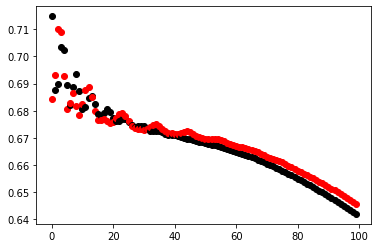

In [ ]:
model = MLP(np.shape(images_train[0])[0],50)
train_model(images_train, labels_train, images_test, labels_test, model)


Write a function called `evaluate_model` which takes the image data, labels and model as input, and the accuracy as output. you can use the `accuracy_score` function.

In [ ]:
# evaluate the model
def evaluate_model(data,labels, model):
  yhat = model(data)
  yhat = yhat.detach().numpy()
  best_class = np.argmax(yhat,axis=1)
  acc = accuracy_score(best_class,np.argmax(labels,axis=1))
  return(acc)
# evaluate the model
acc = evaluate_model(images_test,labels_test, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.631


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


**Problem 3d** make a confusion matrix for the test set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


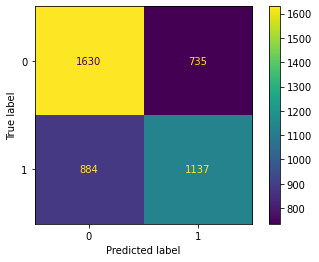

In [ ]:
yhat = model(images_test)
yhat = yhat.detach().numpy()
best_class = np.argmax(yhat,axis=1)
truth = np.argmax(labels_test,axis=1)
cm = confusion_matrix(truth,best_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Challenge Problem** Add a third class to your classifier and begin accounting for uneven classes. There are several steps to this:

1. Edit the neural network to output 3 classes
2. Change the criterion to a *custom criterion* function, such that the entropy of each class is weighted by the inverse fraction of each class size (e.g., if the galaxy class breakdowns are 1:2:3, the weights would be 6:3:2). 

In [ ]:
class MLP_new(torch.nn.Module):
      # this defines the model
        def __init__(self, input_size, hidden_size):
            super(MLP_new, self).__init__()
            print(input_size,hidden_size)
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.hiddenlayer = torch.nn.Linear(self.input_size, self.hidden_size)
            self.outputlayer = torch.nn.Linear(self.hidden_size, 3)
            self.sigmoid = torch.nn.Sigmoid()
            self.softmax = torch.nn.Softmax()
        def forward(self, x):
            layer1 = self.hiddenlayer(x)
            activation = self.sigmoid(layer1)
            layer2 = self.outputlayer(activation)
            activation2 = self.sigmoid(layer1)
            layer3 = self.outputlayer(activation2)
            output = self.softmax(layer3)
            return output

In [ ]:

#Only work with 0,1,2
gind = np.where((labels_original==0) | (labels_original==1) | (labels_original==2))
images_top_three = images[gind]
labels_top_three = labels_original[gind]


x,counts = np.unique(labels_top_three,return_counts=True)
print(counts)


torch.set_default_dtype(torch.float)
labels_top_three_one_hot = F.one_hot(torch.tensor(labels_top_three - np.min(labels_top_three)).long(), num_classes=3)
images_top_three = torch.tensor(images_top_three).float()
labels_top_three_one_hot = labels_top_three_one_hot.float()
# we're going to flatten the images for our MLP
images_top_three_flat = images_top_three.reshape(len(images_top_three),-1)

#Normalize the flux of the images here
images_top_three_flat = (images_top_three_flat  - torch.mean(images_top_three_flat))/torch.std(images_top_three_flat)
images_train, images_test, labels_train, labels_test = train_test_split(
    images_top_three_flat, labels_top_three_one_hot, test_size=0.33, random_state=42)


[3461 6997 6292]


In [ ]:
# train the model
def train_model(training_data,training_labels, test_data,test_labels, model):
  # define the optimization
  criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(np.sum(counts)/counts))
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005,momentum=0.9)
  for epoch in range(100):
    # clear the gradient
    optimizer.zero_grad()
    # compute the model output
    myoutput = model(training_data)
    # calculate loss
    loss = criterion(myoutput, training_labels)
    # credit assignment
    loss.backward()
    # update model weights
    optimizer.step()

    # STUDENTS ADD THIS PART
    output_test = model(test_data)
    loss_test = criterion(output_test, test_labels)
    plt.plot(epoch,loss.detach().numpy(),'ko')
    plt.plot(epoch,loss_test.detach().numpy(),'ro')
    print(epoch,loss.detach().numpy())
  plt.show()  

14283 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 3.3195717
1 3.3145347
2 3.3061361
3 3.2964878
4 3.2872322
5 3.278995
6 3.2715807
7 3.2644916
8 3.2572856
9 3.249736
10 3.2418785
11 3.2339673
12 3.2263515
13 3.219309
14 3.2129354
15 3.2071357
16 3.2016828
17 3.196325
18 3.190885
19 3.1853273
20 3.1797526
21 3.1743371
22 3.1692338
23 3.1644976
24 3.1600723
25 3.1558292
26 3.1516392
27 3.1474195
28 3.1431549
29 3.1388838
30 3.1346703
31 3.13058
32 3.1266615
33 3.122941
34 3.1194153
35 3.1160555
36 3.112815
37 3.1096437
38 3.1065123
39 3.103416
40 3.1003761
41 3.0974233
42 3.0945818
43 3.0918584
44 3.0892408
45 3.0867085
46 3.0842416
47 3.0818293
48 3.0794687
49 3.0771616
50 3.0749097
51 3.072713
52 3.0705707
53 3.068482
54 3.0664432
55 3.0644524
56 3.0625052
57 3.060599
58 3.0587308
59 3.0569017
60 3.0551121
61 3.0533662
62 3.051664
63 3.0500057
64 3.0483887
65 3.0468102
66 3.0452676
67 3.0437596
68 3.0422845
69 3.040843
70 3.0394335
71 3.038056
72 3.0367076
73 3.0353887
74 3.0340974
75 3.0328321
76 3.031592
77 3.030375
78 3.0291803
7

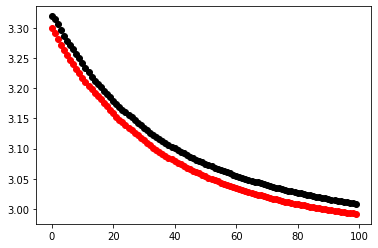

In [ ]:
model = MLP_new(np.shape(images_train[0])[0],50)
train_model(images_train, labels_train, images_test, labels_test, model)


In [ ]:
# evaluate the model
def evaluate_model(data,labels, model):
  yhat = model(data)
  yhat = yhat.detach().numpy()
  best_class = np.argmax(yhat,axis=1)
  acc = accuracy_score(best_class,np.argmax(labels,axis=1))
  return(acc)
# evaluate the model
acc = evaluate_model(images_test,labels_test, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


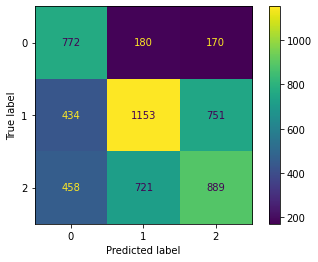

In [ ]:
yhat = model(images_test)
yhat = yhat.detach().numpy()
best_class = np.argmax(yhat,axis=1)
truth = np.argmax(labels_test,axis=1)
cm = confusion_matrix(truth,best_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()